<a href="https://colab.research.google.com/github/wayneotemah/Learing-TensorFlow/blob/main/transfer_learining_3_scaling_up.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer learing with tensorflow part 3 Scaling up (🍲👁️)

In [ ]:
!nvidia-smi

Mon Jun  5 09:15:53 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   70C    P0    32W /  70W |   4971MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import datetime
print(f"Notebook last run end-to-end: {datetime.datetime.now()}")

Notebook last run end-to-end: 2023-06-05 09:16:15.593418


## helper funtions

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-06-05 09:16:15--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.1’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-06-05 09:16:15 (104 MB/s) - ‘helper_functions.py.1’ saved [10246/10246]



In [ ]:
from helper_functions import *

## Downloading and processing the data

In [ ]:

# Download data from Google Storage (already preformatted)
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip 

unzip_data("101_food_classes_10_percent.zip")

train_dir = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"

--2023-06-05 09:16:15--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.24.128, 142.250.4.128, 142.251.10.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.24.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip.1’

101_food_classes_10 100%[===================>]   1.51G  17.6MB/s    in 93s     

2023-06-05 09:17:49 (16.7 MB/s) - ‘101_food_classes_10_percent.zip.1’ saved [1625420029/1625420029]



In [ ]:
walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/train'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/macaroni_and_cheese'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/baby_back_ribs'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/spaghetti_bolognese'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/onion_rings'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/bread_pudding'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/seaweed_salad'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/creme_brulee'.
There are 0 director

## Setup data input

In [ ]:
import tensorflow as tf
IMG_SIZE = (224,224)
train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                label_mode="categorical",
                                                                                image_size = IMG_SIZE)

test_data= tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size = IMG_SIZE,
                                                                shuffle = False
                                                                )

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


from keras.engine.sequential import layer_module
## Train a big dog model with transfer learning on 10% of 101 food classes

Steps:

* Create a modelCheckpoint callback ✅
* create data augentation layer_module
* Build a headless Funtional EfficentNetBo backbone-model
* Compile our model
* Feature extraction for 5 ful passess(5 epocks on thh training dataset)

In [ ]:
# check point callback
from keras.saving.saving_api import save_weights
checkpoint_path = "101_classes_10_percent_data_model_checkpoint"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,save_weights_only=True,monitor="val_accuracy",save_based_only = True)

In [ ]:
# data augmentation layer

from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

# set up data augmentation

data_augmentaion = Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomHeight(0.2),
    layers.RandomWidth(0.2),
],name = "data_augmentation")



In [ ]:
from keras.layers.serialization import activation
from tensorflow.python import training
# Setup base model and freeze its layers (this will extract features)
base_model = tf.keras.applications.efficientnet.EfficientNetB0(include_top=False)
base_model.trainable = False


# set up model architecutre 
inputs = layers.Input(shape = (224,224,3),name = "input_layer")
x = data_augmentaion(inputs)
x = base_model(x,training=False)
x = layers.GlobalAveragePooling2D(name = "global_avarage_pool")(x)
outputs = layers.Dense(len(train_data_all_10_percent.class_names),activation="softmax",name="output_layer")(x)
model = tf.keras.Model(inputs,outputs)



In [ ]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_avarage_pool (Global  (None, 1280)             0         
 AveragePooling2D)                                               
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-train

In [ ]:

# Compile
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(), # use Adam with default settings
              metrics=["accuracy"])

# Fit
history_all_classes_10_percent = model.fit(train_data_all_10_percent,
                                           epochs=5, # fit for 5 epochs to keep experiments quick
                                           validation_data=test_data,
                                           validation_steps=int(0.15 * len(test_data)), # evaluate on smaller portion of test data
                                           callbacks=[checkpoint_callback]) # save best model weights to file
     


Epoch 1/5
237/237 [==============================] - 55s 202ms/step - loss: 3.3761 - accuracy: 0.2733 - val_loss: 2.5158 - val_accuracy: 0.4484
Epoch 2/5
237/237 [==============================] - 42s 177ms/step - loss: 2.2040 - accuracy: 0.4943 - val_loss: 2.0788 - val_accuracy: 0.4981
Epoch 3/5
237/237 [==============================] - 42s 175ms/step - loss: 1.8223 - accuracy: 0.5642 - val_loss: 1.8885 - val_accuracy: 0.5257
Epoch 4/5
237/237 [==============================] - 42s 177ms/step - loss: 1.6042 - accuracy: 0.6136 - val_loss: 1.8255 - val_accuracy: 0.5307
Epoch 5/5
237/237 [==============================] - 40s 168ms/step - loss: 1.4494 - accuracy: 0.6471 - val_loss: 1.7571 - val_accuracy: 0.5432


In [ ]:

# Evaluate model 
results_feature_extraction_model = model.evaluate(test_data)
results_feature_extraction_model

790/790 [==============================] - 73s 92ms/step - loss: 1.5766 - accuracy: 0.5839


[1.5766198635101318, 0.5839207768440247]

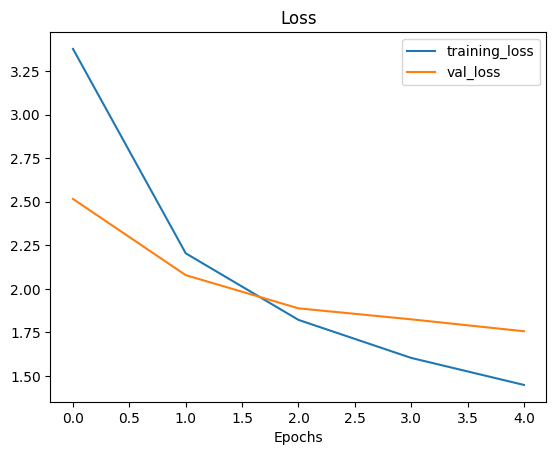

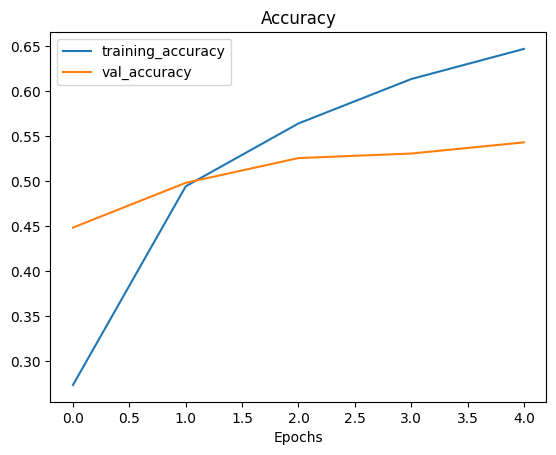

In [ ]:

plot_loss_curves(history_all_classes_10_percent)

#Fine tuning

In [ ]:
# unfreese all the layer in base model

In [ ]:
base_model.trainable = True

# Refreeze every layer except the last 5
for layer in base_model.layers[:-5]:
  layer.trainable = False

In [ ]:
1e-4

0.0001

In [ ]:

# Recompile model with lower learning rate
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(1e-4), # 10x lower learning rate than default
              metrics=['accuracy'])

In [ ]:

# What layers in the model are trainable?
for layer in model.layers:
  print(layer.name, layer.trainable)

input_layer True
data_augmentation True
efficientnetb0 True
global_avarage_pool True
output_layer True


In [ ]:
for layer_number ,layer in enumerate(base_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_2 False
1 rescaling_2 False
2 normalization_1 False
3 rescaling_3 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze Fals

In [ ]:

# Fine-tune for 5 more epochs
fine_tune_epochs = 10 # model has already done 5 epochs, this is the total number of epochs we're after (5+5=10)

history_all_classes_10_percent_fine_tune = model.fit(train_data_all_10_percent,
                                                     epochs=fine_tune_epochs,
                                                     validation_data=test_data,
                                                     validation_steps=int(0.15 * len(test_data)), # validate on 15% of the test data
                                                     initial_epoch=history_all_classes_10_percent.epoch[-1]) # start from previous last epoch
     

Epoch 5/10
237/237 [==============================] - 50s 174ms/step - loss: 1.2157 - accuracy: 0.6862 - val_loss: 1.7045 - val_accuracy: 0.5440
Epoch 6/10
237/237 [==============================] - 39s 165ms/step - loss: 1.0837 - accuracy: 0.7151 - val_loss: 1.7167 - val_accuracy: 0.5410
Epoch 7/10
237/237 [==============================] - 40s 169ms/step - loss: 1.0157 - accuracy: 0.7277 - val_loss: 1.6929 - val_accuracy: 0.5548
Epoch 8/10
237/237 [==============================] - 37s 155ms/step - loss: 0.9360 - accuracy: 0.7473 - val_loss: 1.7104 - val_accuracy: 0.5482
Epoch 9/10
237/237 [==============================] - 40s 168ms/step - loss: 0.8882 - accuracy: 0.7579 - val_loss: 1.7122 - val_accuracy: 0.5485
Epoch 10/10
237/237 [==============================] - 37s 154ms/step - loss: 0.8366 - accuracy: 0.7736 - val_loss: 1.7094 - val_accuracy: 0.5535


In [ ]:

# Evaluate fine-tuned model on the whole test dataset
results_all_classes_10_percent_fine_tune = model.evaluate(test_data)
results_all_classes_10_percent_fine_tune
     


790/790 [==============================] - 63s 79ms/step - loss: 1.4896 - accuracy: 0.6059


[1.4896379709243774, 0.6058613657951355]

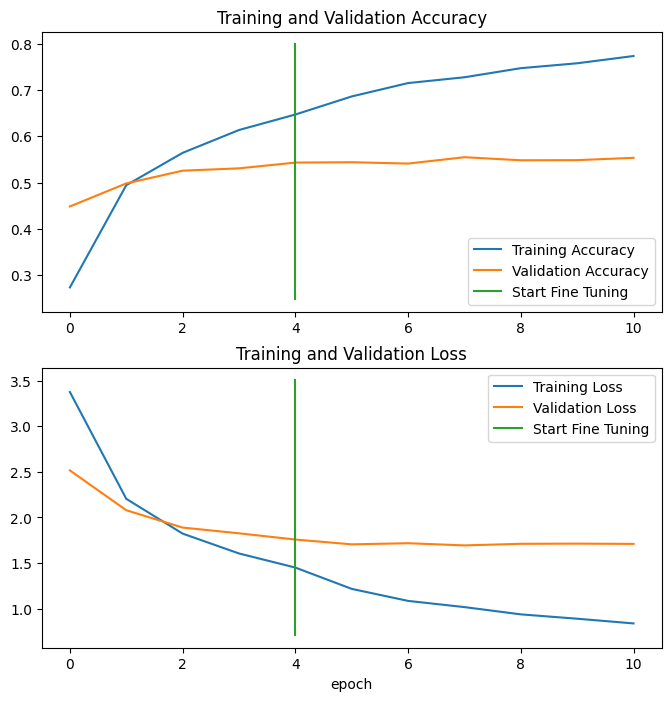

In [ ]:

compare_historys(original_history=history_all_classes_10_percent,
                 new_history=history_all_classes_10_percent_fine_tune,
                 initial_epochs=5)

# save and load model

In [ ]:
tf.saved_model.save(model,"/drive/MyDrive/ML_models/101_foods_big_dog_model")

In [ ]:
 loaded_model = tf.saved_model.load("/drive/MyDrive/ML_models/101_foods_big_dog_model")

In [ ]:

# Check to see if loaded model is a trained model
loaded_loss, loaded_accuracy = model.evaluate(test_data)
loaded_loss, loaded_accuracy


790/790 [==============================] - 63s 80ms/step - loss: 1.4896 - accuracy: 0.6059


(1.4896379709243774, 0.6058613657951355)

In [ ]:
results_all_classes_10_percent_fine_tune

[1.4896379709243774, 0.6058613657951355]

#Evaluating the performance of the big dog model across all different classes

In [ ]:
import tensorflow as tf

# Download pre-trained model from Google Storage (like a cooking show, I trained this model earlier, so the results may be different than above)
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip
saved_model_path = "06_101_food_class_10_percent_saved_big_dog_model.zip"
unzip_data(saved_model_path)

# Note: loading a model will output a lot of 'WARNINGS', these can be ignored: https://www.tensorflow.org/tutorials/keras/save_and_load#save_checkpoints_during_training
# There's also a thread on GitHub trying to fix these warnings: https://github.com/tensorflow/tensorflow/issues/40166
# model = tf.keras.models.load_model("drive/My Drive/tensorflow_course/101_food_class_10_percent_saved_big_dog_model/") # path to drive model
model = tf.keras.models.load_model(saved_model_path.split(".")[0]) # don't include ".zip" in loaded model path

--2023-06-05 09:30:58--  https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.4.128, 142.251.10.128, 142.251.12.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.4.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46760742 (45M) [application/zip]
Saving to: ‘06_101_food_class_10_percent_saved_big_dog_model.zip.1’

06_101_food_class_1 100%[===================>]  44.59M  12.4MB/s    in 3.6s    

2023-06-05 09:31:02 (12.4 MB/s) - ‘06_101_food_class_10_percent_saved_big_dog_model.zip.1’ saved [46760742/46760742]



In [ ]:


# Check to see if loaded model is a trained model
loaded_loss, loaded_accuracy = model.evaluate(test_data)
loaded_loss, loaded_accuracy

790/790 [==============================] - 67s 81ms/step - loss: 1.8027 - accuracy: 0.6078


(1.8027206659317017, 0.6077623963356018)

# make predictions

In [ ]:
preds_probs = model.predict(test_data,verbose=1)

790/790 [==============================] - 68s 84ms/step


In [ ]:
len(preds_probs)

25250

In [ ]:
# shape of predictio
preds_probs.shape

(25250, 101)

In [ ]:
preds_probs[:10]

array([[5.9542079e-02, 3.5742114e-06, 4.1377071e-02, ..., 1.4138705e-09,
        8.3530424e-05, 3.0897493e-03],
       [9.6401680e-01, 1.3753272e-09, 8.4780494e-04, ..., 5.4286946e-05,
        7.8362065e-12, 9.8466024e-10],
       [9.5925868e-01, 3.2533771e-05, 1.4867012e-03, ..., 7.1891407e-07,
        5.4397475e-07, 4.0276118e-05],
       ...,
       [4.7313249e-01, 1.2931206e-07, 1.4805582e-03, ..., 5.9750117e-04,
        6.6969209e-05, 2.3469403e-05],
       [4.4571843e-02, 4.7265397e-07, 1.2258503e-01, ..., 6.3498451e-06,
        7.5318876e-06, 3.6778769e-03],
       [7.2438902e-01, 1.9249717e-09, 5.2310897e-05, ..., 1.2291410e-03,
        1.5792732e-09, 9.6395481e-05]], dtype=float32)

In [ ]:
preds_probs[0],len(preds_probs[0]),sum(preds_probs[0])

(array([5.9542079e-02, 3.5742114e-06, 4.1377071e-02, 1.0660534e-09,
        8.1614422e-09, 8.6639478e-09, 8.0927344e-07, 8.5652732e-07,
        1.9859108e-05, 8.0977674e-07, 3.1727800e-09, 9.8673911e-07,
        2.8532281e-04, 7.8048890e-10, 7.4230117e-04, 3.8916227e-05,
        6.4740480e-06, 2.4977348e-06, 3.7891161e-05, 2.0678284e-07,
        1.5538406e-05, 8.1507324e-07, 2.6230616e-06, 2.0010684e-07,
        8.3827518e-07, 5.4215925e-06, 3.7390960e-06, 1.3150530e-08,
        2.7761441e-03, 2.8051916e-05, 6.8562017e-10, 2.5574853e-05,
        1.6688927e-04, 7.6406986e-10, 4.0452811e-04, 1.3150683e-08,
        1.7957391e-06, 1.4448174e-06, 2.3062844e-02, 8.2466693e-07,
        8.5365679e-07, 1.7138593e-06, 7.0525425e-06, 1.8402130e-08,
        2.8553373e-07, 7.9483443e-06, 2.0681530e-06, 1.8525149e-07,
        3.3619703e-08, 3.1522504e-04, 1.0410941e-05, 8.5448431e-07,
        8.4741855e-01, 1.0555424e-05, 4.4094787e-07, 3.7404032e-05,
        3.5306188e-05, 3.2488941e-05, 6.7314730e

In [ ]:

# We get one prediction probability per class
print(f"Number of prediction probabilities for sample 0: {len(preds_probs[0])}")
print(f"What prediction probability sample 0 looks like:\n {preds_probs[0]}")
print(f"The class with the highest predicted probability by the model for sample 0: {preds_probs[0].argmax()}")

Number of prediction probabilities for sample 0: 101
What prediction probability sample 0 looks like:
 [5.9542079e-02 3.5742114e-06 4.1377071e-02 1.0660534e-09 8.1614422e-09
 8.6639478e-09 8.0927344e-07 8.5652732e-07 1.9859108e-05 8.0977674e-07
 3.1727800e-09 9.8673911e-07 2.8532281e-04 7.8048890e-10 7.4230117e-04
 3.8916227e-05 6.4740480e-06 2.4977348e-06 3.7891161e-05 2.0678284e-07
 1.5538406e-05 8.1507324e-07 2.6230616e-06 2.0010684e-07 8.3827518e-07
 5.4215925e-06 3.7390960e-06 1.3150530e-08 2.7761441e-03 2.8051916e-05
 6.8562017e-10 2.5574853e-05 1.6688927e-04 7.6406986e-10 4.0452811e-04
 1.3150683e-08 1.7957391e-06 1.4448174e-06 2.3062844e-02 8.2466693e-07
 8.5365679e-07 1.7138593e-06 7.0525425e-06 1.8402130e-08 2.8553373e-07
 7.9483443e-06 2.0681530e-06 1.8525149e-07 3.3619703e-08 3.1522504e-04
 1.0410941e-05 8.5448431e-07 8.4741855e-01 1.0555424e-05 4.4094787e-07
 3.7404032e-05 3.5306188e-05 3.2488941e-05 6.7314730e-05 1.2852589e-08
 2.6219654e-10 1.0318089e-05 8.5743537e-05 1.

In [ ]:
test_data.class_names[52]

'gyoza'

In [106]:
# get pred classes of each classes
pred_classes = preds_probs.argmax(axis=1)
np.array([pred_classes])

array([[ 52,   0,   0, ..., 100,  94, 100]])

In [ ]:
test_data

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 101), dtype=tf.float32, name=None))>

In [ ]:

# Note: This might take a minute or so due to unravelling 790 batches
y_labels = []
for images, labels in test_data.unbatch(): # unbatch the test data and get images and labels
  y_labels.append(labels.numpy().argmax()) # append the index which has the largest value (labels are one-hot)
y_labels[:10] # check what they look like (unshuffled)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [ ]:
len(y_labels)

25250

In [ ]:

# Get accuracy score by comparing predicted classes to ground truth labels
from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(y_labels, pred_classes)
sklearn_accuracy

0.6077623762376237

In [ ]:

# Does the evaluate method compare to the Scikit-Learn measured accuracy?
import numpy as np
print(f"Close? {np.isclose(loaded_accuracy, sklearn_accuracy)} | Difference: {loaded_accuracy - sklearn_accuracy}")

Close? True | Difference: 2.0097978059574473e-08


In [ ]:

# Get the class names
class_names = test_data.class_names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [88]:
# Note: The following confusion matrix code is a remix of Scikit-Learn's 
# plot_confusion_matrix function - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Our function needs a different name to sklearn's plot_confusion_matrix
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False): 
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).
  
  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """  
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  ### Added: Rotate xticks for readability & increase font size (required due to such a large confusion matrix)
  plt.xticks(rotation=70, fontsize=text_size)
  plt.yticks(fontsize=text_size)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")

In [ ]:

# Plot a confusion matrix with all 25250 predictions, ground truth labels and 101 classes
make_confusion_matrix(y_true=y_labels,
                      y_pred=pred_classes,
                      classes=class_names,
                      figsize=(100, 100),
                      text_size=20,
                      norm=False,
                      savefig=True)

# classification report

In [ ]:

from sklearn.metrics import classification_report
print(classification_report(y_labels, pred_classes))

In [ ]:

# Get a dictionary of the classification report
classification_report_dict = classification_report(y_labels, pred_classes, output_dict=True)
classification_report_dict

In [ ]:

# Create empty dictionary
class_f1_scores = {}
# Loop through classification report items
for k, v in classification_report_dict.items():
  if k == "accuracy": # stop once we get to accuracy key
    break
  else:
    # Append class names and f1-scores to new dictionary
    class_f1_scores[class_names[int(k)]] = v["f1-score"]
class_f1_scores

In [ ]:

# Turn f1-scores into dataframe for visualization
import pandas as pd
f1_scores = pd.DataFrame({"class_name": list(class_f1_scores.keys()),
                          "f1-score": list(class_f1_scores.values())}).sort_values("f1-score", ascending=False)
f1_scores

In [ ]:
import altair as alt
from google.colab import autoviz
df_1849023973963713960 = autoviz.get_registered_df('df_1849023973963713960')

def value_plot(df, y, sort_ascending=False, width=100, height=50):
  if sort_ascending:
    df = df.sort_values(y).reset_index(drop=True)
  return (alt.Chart(df.reset_index()).mark_line()
          .encode(x=alt.X('index', title=''), y=alt.X(y, title='value'))
          .properties(width=width, height=height, title=y))

chart = value_plot(df_1849023973963713960, *['f1-score'], **{})
chart

In [ ]:

import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 25))
scores = ax.barh(range(len(f1_scores)), f1_scores["f1-score"].values)
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(list(f1_scores["class_name"]))
ax.set_xlabel("f1-score")
ax.set_title("F1-Scores for 10 Different Classes")
ax.invert_yaxis(); # reverse the order

def autolabel(rects): # Modified version of: https://matplotlib.org/examples/api/barchart_demo.html
  """
  Attach a text label above each bar displaying its height (it's value).
  """
  for rect in rects:
    width = rect.get_width()
    ax.text(1.03*width, rect.get_y() + rect.get_height()/1.5,
            f"{width:.2f}",
            ha='center', va='bottom')

autolabel(scores)

In [98]:

def load_and_prep_image(filename, img_shape=224, scale=True):
  """
  Reads in an image from filename, turns it into a tensor and reshapes into
  (224, 224, 3).

  Parameters
  ----------
  filename (str): string filename of target image
  img_shape (int): size to resize target image to, default 224
  scale (bool): whether to scale pixel values to range(0, 1), default True
  """
  # Read in the image
  img = tf.io.read_file(filename)
  # Decode it into a tensor
  img = tf.io.decode_image(img,channels=3)
  # Resize the image
  img = tf.image.resize(img, [img_shape, img_shape])
  if scale:
    # Rescale the image (get all values between 0 and 1)
    return img/255.
  else:
    return img
     

1/1 [==============================] - 0s 31ms/step


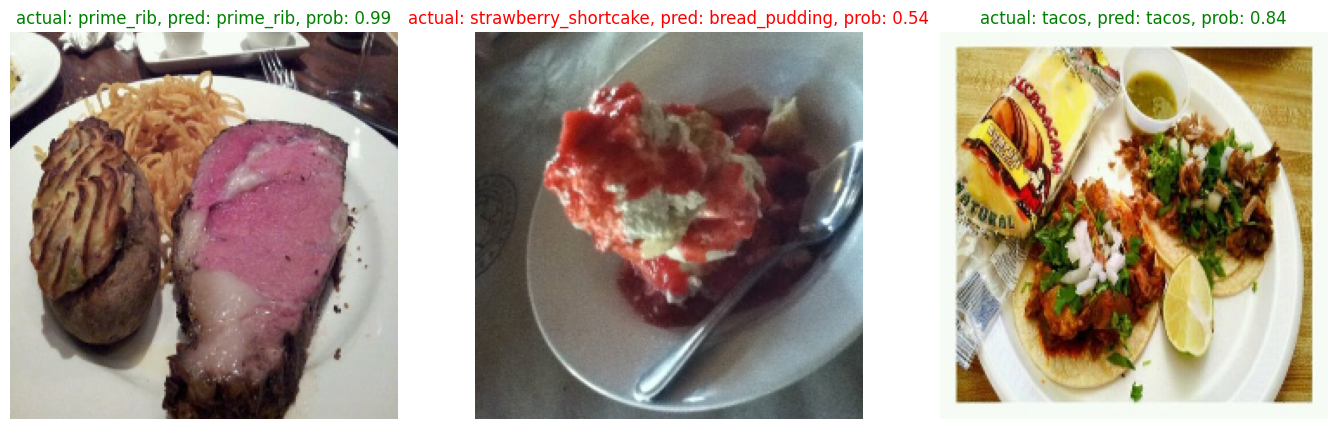

In [102]:

# Make preds on a series of random images
import os
import random

plt.figure(figsize=(17, 10))
for i in range(3):
  # Choose a random image from a random class 
  class_name = random.choice(class_names)
  filename = random.choice(os.listdir(test_dir + "/" + class_name))
  filepath = test_dir + class_name + "/" + filename

  # Load the image and make predictions
  img = load_and_prep_image(filepath, scale=False) # don't scale images for EfficientNet predictions
  pred_prob = model.predict(tf.expand_dims(img, axis=0)) # model accepts tensors of shape [None, 224, 224, 3]
  pred_class = class_names[pred_prob.argmax()] # find the predicted class 

  # Plot the image(s)
  plt.subplot(1, 3, i+1)
  plt.imshow(img/255.)
  if class_name == pred_class: # Change the color of text based on whether prediction is right or wrong
    title_color = "g"
  else:
    title_color = "r" 
  plt.title(f"actual: {class_name}, pred: {pred_class}, prob: {pred_prob.max():.2f}", c=title_color)
  plt.axis(False);

In [103]:


# 1. Get the filenames of all of our test data
filepaths = []
for filepath in test_data.list_files("101_food_classes_10_percent/test/*/*.jpg", 
                                     shuffle=False):
  filepaths.append(filepath.numpy())
filepaths[:10]

[b'101_food_classes_10_percent/test/apple_pie/1011328.jpg',
 b'101_food_classes_10_percent/test/apple_pie/101251.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1034399.jpg',
 b'101_food_classes_10_percent/test/apple_pie/103801.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1038694.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1047447.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1068632.jpg',
 b'101_food_classes_10_percent/test/apple_pie/110043.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1106961.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1113017.jpg']

In [108]:

# 2. Create a dataframe out of current prediction data for analysis
import pandas as pd
pred_df = pd.DataFrame({"img_path": filepaths,
                        "y_true": y_labels,
                        "y_pred": pred_classes,
                        "pred_conf": preds_probs.max(axis=1), # get the maximum prediction probability value
                        "y_true_classname": [class_names[i] for i in y_labels],
                        "y_pred_classname": [class_names[i] for i in pred_classes]}) 
pred_df.head()

img_path  y_true  y_pred  \
0  b'101_food_classes_10_percent/test/apple_pie/1...       0      52   
1  b'101_food_classes_10_percent/test/apple_pie/1...       0       0   
2  b'101_food_classes_10_percent/test/apple_pie/1...       0       0   
3  b'101_food_classes_10_percent/test/apple_pie/1...       0      80   
4  b'101_food_classes_10_percent/test/apple_pie/1...       0      79   

   pred_conf y_true_classname      y_pred_classname  
0   0.847419        apple_pie                 gyoza  
1   0.964017        apple_pie             apple_pie  
2   0.959259        apple_pie             apple_pie  
3   0.658606        apple_pie  pulled_pork_sandwich  
4   0.367900        apple_pie             prime_rib

In [111]:

# 3. Is the prediction correct?
pred_df["pred_correct"] = pred_df["y_true"] == pred_df["y_pred"]
pred_df.head()
     

img_path  y_true  y_pred  \
0  b'101_food_classes_10_percent/test/apple_pie/1...       0      52   
1  b'101_food_classes_10_percent/test/apple_pie/1...       0       0   
2  b'101_food_classes_10_percent/test/apple_pie/1...       0       0   
3  b'101_food_classes_10_percent/test/apple_pie/1...       0      80   
4  b'101_food_classes_10_percent/test/apple_pie/1...       0      79   

   pred_conf y_true_classname      y_pred_classname  pred_correct  
0   0.847419        apple_pie                 gyoza         False  
1   0.964017        apple_pie             apple_pie          True  
2   0.959259        apple_pie             apple_pie          True  
3   0.658606        apple_pie  pulled_pork_sandwich         False  
4   0.367900        apple_pie             prime_rib         False

In [112]:
# 4. Get the top 100 wrong examples
top_100_wrong = pred_df[pred_df["pred_correct"] == False].sort_values("pred_conf", ascending=False)[:100]
top_100_wrong.head(20)

img_path  y_true  y_pred  \
21810  b'101_food_classes_10_percent/test/scallops/17...      87      29   
231    b'101_food_classes_10_percent/test/apple_pie/8...       0     100   
15359  b'101_food_classes_10_percent/test/lobster_rol...      61      53   
23539  b'101_food_classes_10_percent/test/strawberry_...      94      83   
21400  b'101_food_classes_10_percent/test/samosa/3140...      85      92   
24540  b'101_food_classes_10_percent/test/tiramisu/16...      98      83   
2511   b'101_food_classes_10_percent/test/bruschetta/...      10      61   
5574   b'101_food_classes_10_percent/test/chocolate_m...      22      21   
17855  b'101_food_classes_10_percent/test/paella/2314...      71      65   
23797  b'101_food_classes_10_percent/test/sushi/16593...      95      86   
18001  b'101_food_classes_10_percent/test/pancakes/10...      72      67   
11642  b'101_food_classes_10_percent/test/garlic_brea...      46      10   
10847  b'101_food_classes_10_percent/test/fried_calam...      43      68   
23631  b'101_food_classes_10_percent/test/strawberry_...      94      83   
1155   b'101_food_classes_10_percent/test/beef_tartar...       4       5   
10854  b'101_food_classes_10_percent/test/fried_calam...      43      68   
23904  b'101_food_classes_10_percent/test/sushi/33652...      95      86   
7316   b'101_food_classes_10_percent/test/cup_cakes/1...      29      83   
13144  b'101_food_classes_10_percent/test/gyoza/31214...      52      92   
10880  b'101_food_classes_10_percent/test/fried_calam...      43      68   

       pred_conf       y_true_classname       y_pred_classname  pred_correct  
21810   0.999997               scallops              cup_cakes         False  
231     0.999995              apple_pie                waffles         False  
15359   0.999988  lobster_roll_sandwich              hamburger         False  
23539   0.999987   strawberry_shortcake        red_velvet_cake         False  
21400   0.999981                 samosa           spring_rolls         False  
24540   0.999947               tiramisu        red_velvet_cake         False  
2511    0.999945             bruschetta  lobster_roll_sandwich         False  
5574    0.999939       chocolate_mousse         chocolate_cake         False  
17855   0.999931                 paella                mussels         False  
23797   0.999904                  sushi                sashimi         False  
18001   0.999904               pancakes               omelette         False  
11642   0.999877           garlic_bread             bruschetta         False  
10847   0.999872         fried_calamari            onion_rings         False  
23631   0.999858   strawberry_shortcake        red_velvet_cake         False  
1155    0.999858           beef_tartare             beet_salad         False  
10854   0.999854         fried_calamari            onion_rings         False  
23904   0.999823                  sushi                sashimi         False  
7316    0.999816              cup_cakes        red_velvet_cake         False  
13144   0.999799                  gyoza           spring_rolls         False  
10880   0.999778         fried_calamari            onion_rings         False

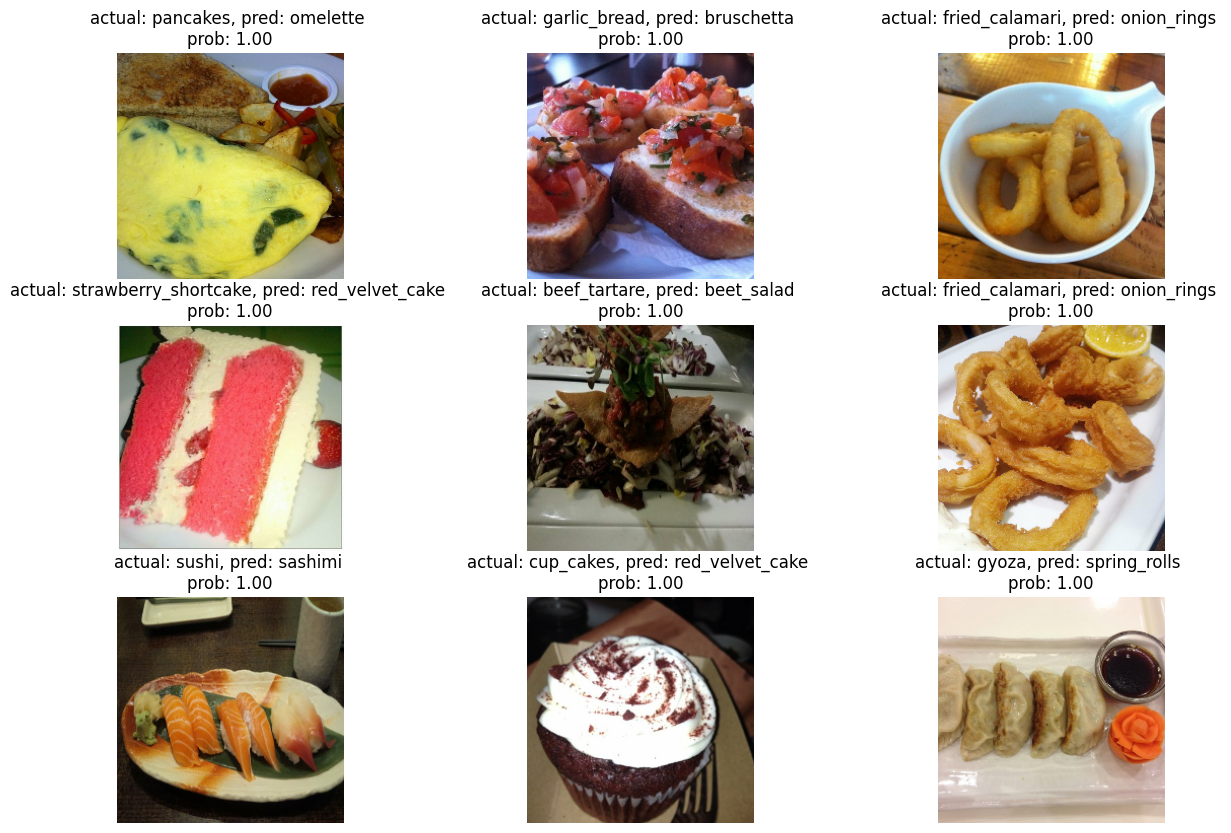

In [113]:

# 5. Visualize some of the most wrong examples
images_to_view = 9
start_index = 10 # change the start index to view more
plt.figure(figsize=(15, 10))
for i, row in enumerate(top_100_wrong[start_index:start_index+images_to_view].itertuples()): 
  plt.subplot(3, 3, i+1)
  img = load_and_prep_image(row[1], scale=True)
  _, _, _, _, pred_prob, y_true, y_pred, _ = row # only interested in a few parameters of each row
  plt.imshow(img)
  plt.title(f"actual: {y_true}, pred: {y_pred} \nprob: {pred_prob:.2f}")
  plt.axis(False)

In [114]:

# Download some custom images from Google Storage
# Note: you can upload your own custom images to Google Colab using the "upload" button in the Files tab
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip

unzip_data("custom_food_images.zip")

--2023-06-05 10:37:23--  https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.4.128, 142.251.10.128, 142.251.12.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.4.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13192985 (13M) [application/zip]
Saving to: ‘custom_food_images.zip’

custom_food_images. 100%[===================>]  12.58M  7.63MB/s    in 1.6s    

2023-06-05 10:37:25 (7.63 MB/s) - ‘custom_food_images.zip’ saved [13192985/13192985]



In [115]:

# Get custom food images filepaths
custom_food_images = ["custom_food_images/" + img_path for img_path in os.listdir("custom_food_images")]
custom_food_images

['custom_food_images/sushi.jpeg',
 'custom_food_images/chicken_wings.jpeg',
 'custom_food_images/pizza-dad.jpeg',
 'custom_food_images/ramen.jpeg',
 'custom_food_images/steak.jpeg',
 'custom_food_images/hamburger.jpeg']

1/1 [==============================] - 0s 28ms/step


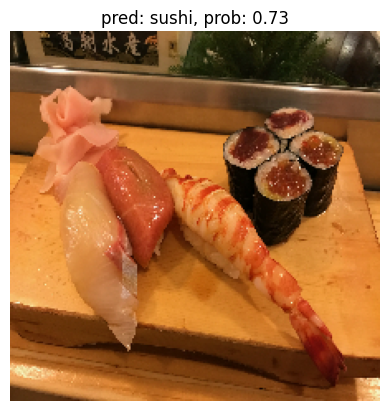

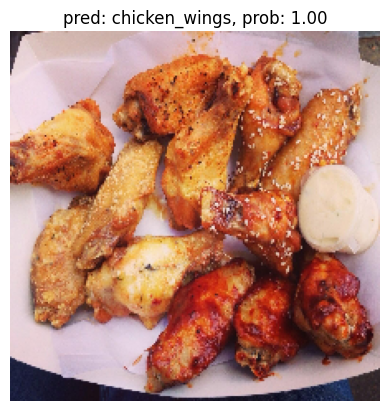

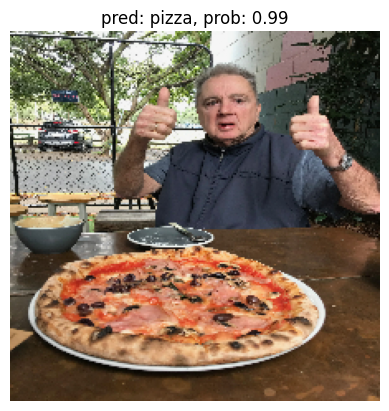

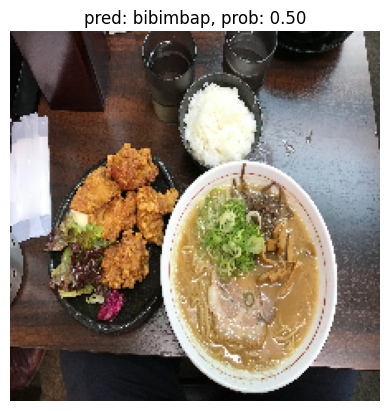

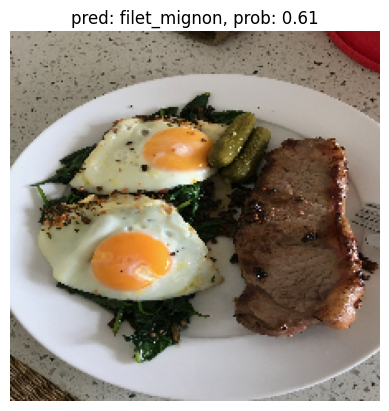

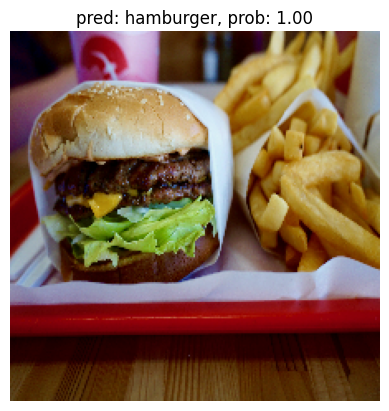

In [116]:

# Make predictions on custom food images
for img in custom_food_images:
  img = load_and_prep_image(img, scale=False) # load in target image and turn it into tensor
  pred_prob = model.predict(tf.expand_dims(img, axis=0)) # make prediction on image with shape [None, 224, 224, 3]
  pred_class = class_names[pred_prob.argmax()] # find the predicted class label
  # Plot the image with appropriate annotations
  plt.figure()
  plt.imshow(img/255.) # imshow() requires float inputs to be normalized
  plt.title(f"pred: {pred_class}, prob: {pred_prob.max():.2f}")
  plt.axis(False)